#Mall Customer Segmentation
**Introduction:**

So the whole idea here was just to see if mall customers could be grouped somehow. I only looked at their income and how much they spend because that already feels like enough to tell people apart. Makes sense, right? Some folks make a lot but don’t spend much, others spend a lot even on a normal income. If you treat everyone as one big group you miss that difference. I decided to try clustering — K-Means (the usual one) and DBSCAN (a bit different, doesn’t force everyone into clusters). Curious to see which worked better.

In [9]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
np.random.seed(42)


In [10]:
GIST_RAW_URL = "https://gist.githubusercontent.com/pravalliyaram/5c05f43d2351249927b8a3f3cc3e5ecf/raw/Mall_Customers.csv"
LOCAL_FILENAME = "Mall_Customers.csv"

def download_if_needed(url=GIST_RAW_URL, fname=LOCAL_FILENAME):
    if os.path.exists(fname):
        print(f"{fname} already exists — using local copy.")
        return True
    try:
        import requests
        print(f"Downloading dataset from {url} ...")
        resp = requests.get(url, timeout=20)
        resp.raise_for_status()
        with open(fname, "wb") as f:
            f.write(resp.content)
        print("Download OK.")
        return True
    except Exception as e:
        print("Download via requests failed:", str(e))
        try:
            print("Trying wget ...")
            !wget -q -O {fname} "{url}"
            if os.path.exists(fname):
                print("Downloaded via wget.")
                return True
        except Exception as e2:
            print("wget attempt failed:", e2)
    return False

ok = download_if_needed()
if not ok:
    print("\n---\nAutomatic download failed. Two options:")
    print("1) Upload Mall_Customers.csv directly into Colab (left sidebar → Files → Upload).")
    print("2) Use Kaggle API: upload your kaggle.json and run:")
    print("   !pip install kaggle")
    print("   mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json")
    print("   !kaggle datasets download -d shwetabh123/mall-customers -f Mall_Customers.csv -p .")
    raise SystemExit("Dataset not available. Upload file or use Kaggle method above.")


Download OK.


# Loading dataset
I loaded the dataset, nothing fancy, just pandas, numpy, matplotlib. Out of all the columns, I kept only Annual Income and Spending Score. Felt like the rest wasn’t really needed here. One problem though: the values are on different scales. Income numbers are much bigger than spending scores, so I had to standardize them. Otherwise the algorithm would care way too much about income and ignore the spending part.

In [11]:
def load_mall_csv(fname=LOCAL_FILENAME):
    try:
        df = pd.read_csv(fname, engine='python')
    except Exception as e:
        df = pd.read_csv(fname, sep=r'\s+', engine='python', header=0)
    df.columns = [c.strip().replace('\ufeff','') for c in df.columns]
    col_map = {}
    for c in df.columns:
        lc = c.lower()
        if 'annual' in lc and 'income' in lc:
            col_map[c] = 'Annual Income'
        elif 'spending' in lc and 'score' in lc:
            col_map[c] = 'Spending Score'
        elif 'age'==lc or 'age' in lc:
            col_map[c] = 'Age'
        elif 'gender' in lc:
            col_map[c] = 'Gender'
        elif 'customer' in lc and 'id' in lc:
            col_map[c] = 'CustomerID'
    if col_map:
        df = df.rename(columns=col_map)
    df['Annual Income'] = pd.to_numeric(df['Annual Income'], errors='coerce')
    df['Spending Score'] = pd.to_numeric(df['Spending Score'], errors='coerce')
    return df

df = load_mall_csv()
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
df.head()


Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income', 'Spending Score']
Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [12]:
print("Missing values per column:")
print(df.isnull().sum())
df = df.dropna(subset=['Annual Income', 'Spending Score']).reset_index(drop=True)
print("After dropping missing rows:", df.shape)
df.describe()


Missing values per column:
CustomerID        0
Gender            0
Age               0
Annual Income     0
Spending Score    0
dtype: int64
After dropping missing rows: (200, 5)


,CustomerID,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


# Exploratory Visualization explanation.
Before jumping in, I made a scatter plot just to eyeball the data. Didn’t expect much, but honestly it already showed something interesting. People with the same income were spending very differently. So yeah, there seemed to be patterns that clustering could catch. Not super clear, but enough to make me keep going.

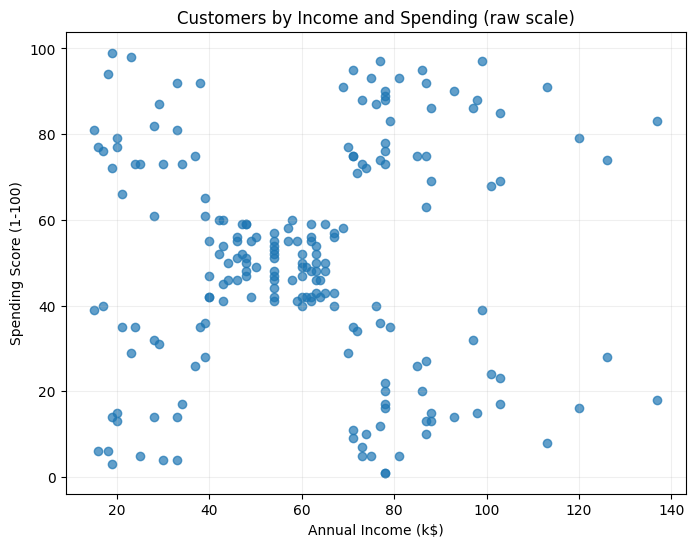

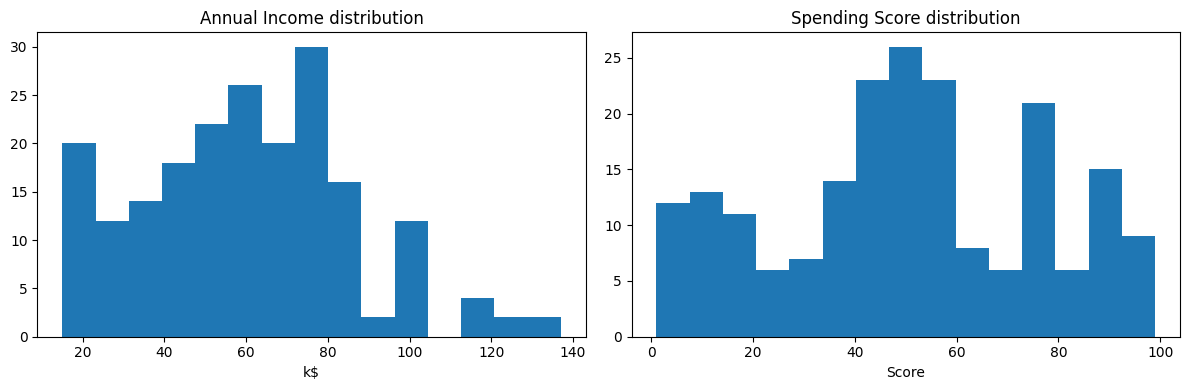

In [13]:
plt.scatter(df['Annual Income'], df['Spending Score'], alpha=0.7)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Customers by Income and Spending (raw scale)")
plt.grid(alpha=0.2)
plt.show()
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(df['Annual Income'], bins=15)
axes[0].set_title("Annual Income distribution")
axes[0].set_xlabel("k$")
axes[1].hist(df['Spending Score'], bins=15)
axes[1].set_title("Spending Score distribution")
axes[1].set_xlabel("Score")
plt.tight_layout()
plt.show()


# K-Means Clustering
Before jumping in, I made a scatter plot just to eyeball the data. Didn’t expect much, but honestly it already showed something interesting. People with the same income were spending very differently. So yeah, there seemed to be patterns that clustering could catch. Not super clear, but enough to make me keep going.

In [14]:
features = ['Annual Income', 'Spending Score']
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled features shape:", X_scaled.shape)


Scaled features shape: (200, 2)


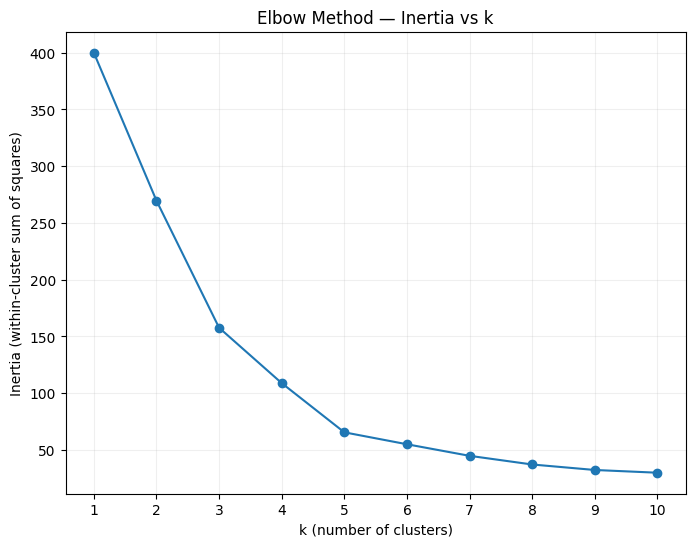

Inertia values: [(1, 400.0), (2, 269.69), (3, 157.7), (4, 108.92), (5, 65.57), (6, 55.06), (7, 44.86), (8, 37.23), (9, 32.39), (10, 29.98)]


In [15]:
inertia = []
K_range = range(1,11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow Method — Inertia vs k")
plt.xticks(K_range)
plt.grid(alpha=0.2)
plt.show()
print("Inertia values:", list(zip(K_range, [float(round(v,2)) for v in inertia])))


In [16]:
sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores[k] = score
    print(f"k={k:2d}  silhouette={score:.4f}")
best_k = max(sil_scores, key=sil_scores.get)
print("\nBest k by silhouette score:", best_k, "score=", sil_scores[best_k])


k= 2  silhouette=0.3213
k= 3  silhouette=0.4666
k= 4  silhouette=0.4939
k= 5  silhouette=0.5547
k= 6  silhouette=0.5399
k= 7  silhouette=0.5281
k= 8  silhouette=0.4552
k= 9  silhouette=0.4571
k=10  silhouette=0.4432

Best k by silhouette score: 5 score= 0.5546571631111091


In [17]:
chosen_k = best_k
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['KMeans_Cluster'] = kmeans_labels
print("KMeans cluster counts:")
print(df['KMeans_Cluster'].value_counts().sort_index())


KMeans cluster counts:
KMeans_Cluster
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


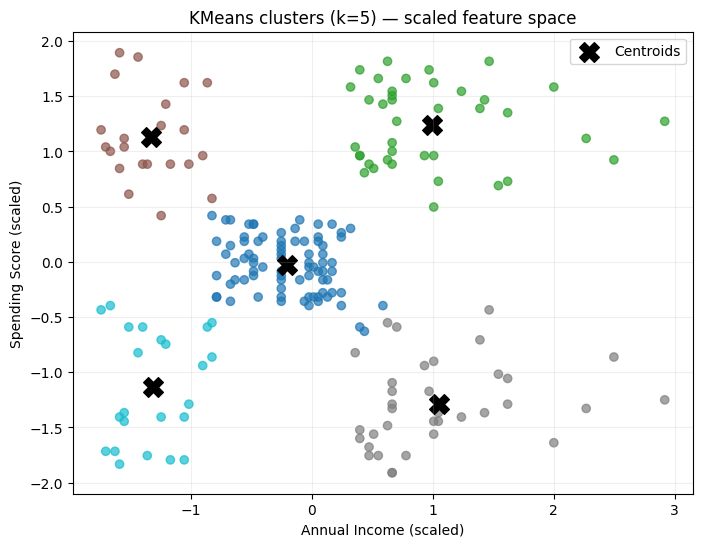

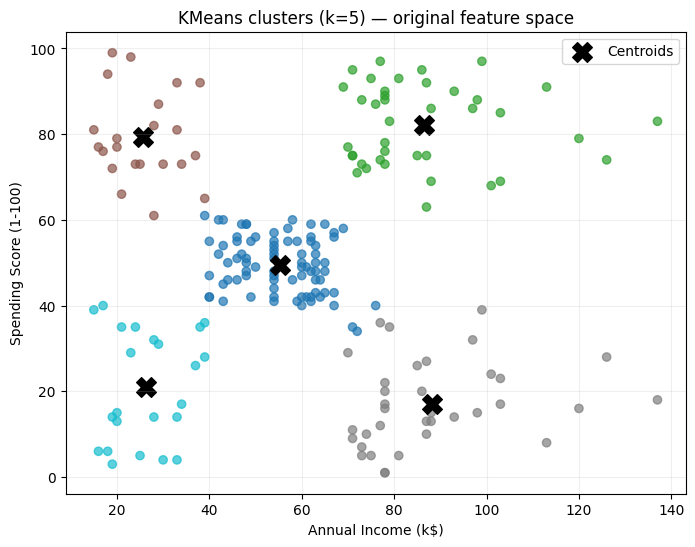

In [18]:
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans_labels, cmap='tab10', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            marker='X', s=200, c='k', label='Centroids')
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title(f"KMeans clusters (k={chosen_k}) — scaled feature space")
plt.legend()
plt.grid(alpha=0.2)
plt.show()
centers_orig = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(df['Annual Income'], df['Spending Score'], c=kmeans_labels, cmap='tab10', alpha=0.7)
plt.scatter(centers_orig[:,0], centers_orig[:,1], marker='X', s=200, c='k', label='Centroids')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title(f"KMeans clusters (k={chosen_k}) — original feature space")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


# DBSCAN Clustering
With K-Means, the hard part was picking k. I checked the elbow graph and the silhouette score — both hinted at around 5. So I just went with k=5. When I ran it, the clusters actually looked quite neat on the plot. Different colors, red crosses for the centers. You could clearly see groups. I then looked at the averages for each cluster and, yeah, some groups were obvious. One had high-income but low-spending customers (which I found kinda surprising). Another group had moderate income but high spending, definitely the more valuable group.

In [19]:
kmeans_summary = df.groupby('KMeans_Cluster')[['Annual Income','Spending Score']].agg(['count','mean','std'])
kmeans_summary.columns = ['_'.join(col).strip() for col in kmeans_summary.columns.values]
kmeans_summary = kmeans_summary.sort_index()
display(kmeans_summary)


,Annual Income_count,Annual Income_mean,Annual Income_std,Spending Score_count,Spending Score_mean,Spending Score_std
KMeans_Cluster,,,,,,
0,81,55.296296,8.988109,81,49.518519,6.530909
1,39,86.538462,16.312485,39,82.128205,9.364489
2,22,25.727273,7.566731,22,79.363636,10.504174
3,35,88.200000,16.399067,35,17.114286,9.952154
4,23,26.304348,7.893811,23,20.913043,13.017167


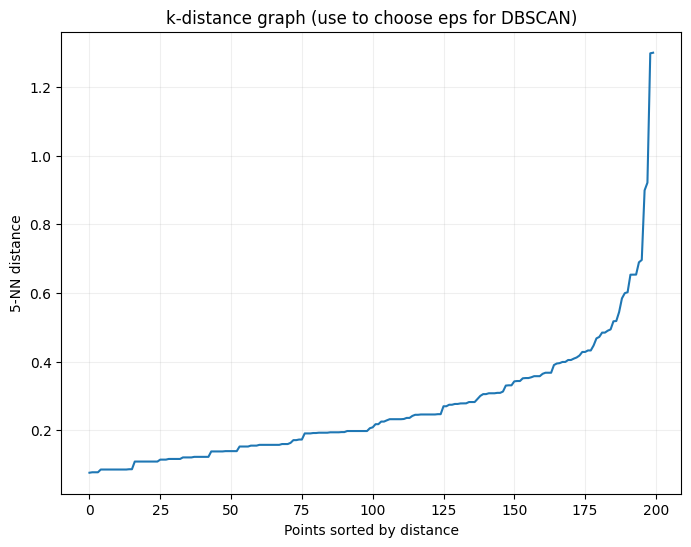

In [20]:
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
kdist = np.sort(distances[:, -1])
plt.plot(kdist)
plt.ylabel(f"{min_samples}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("k-distance graph (use to choose eps for DBSCAN)")
plt.grid(alpha=0.2)
plt.show()


In [21]:
dbscan_eps = 0.5
dbscan_min_samples = min_samples

db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
db_labels = db.fit_predict(X_scaled)
df['DBSCAN_Cluster'] = db_labels
print("DBSCAN labels distribution (noise = -1):")
print(df['DBSCAN_Cluster'].value_counts().sort_index())


DBSCAN labels distribution (noise = -1):
DBSCAN_Cluster
-1      8
 0    157
 1     35
Name: count, dtype: int64


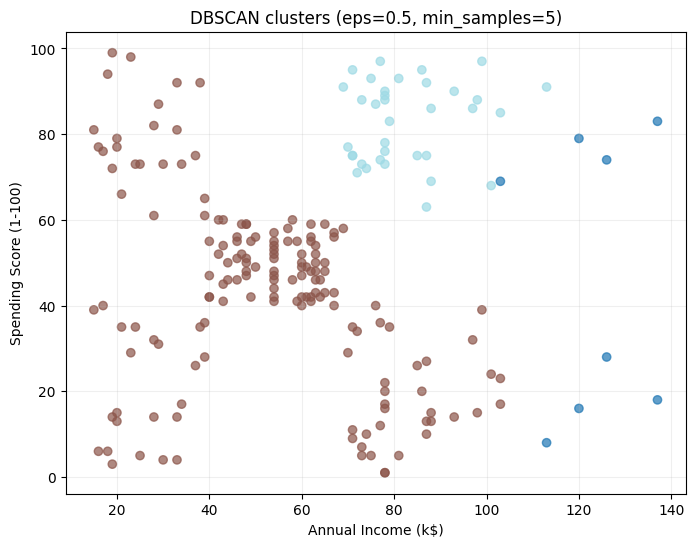

In [22]:
plt.scatter(df['Annual Income'], df['Spending Score'], c=df['DBSCAN_Cluster'], cmap='tab20', alpha=0.7)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title(f"DBSCAN clusters (eps={dbscan_eps}, min_samples={dbscan_min_samples})")
plt.grid(alpha=0.2)
plt.show()


In [23]:
dbscan_summary = df.groupby('DBSCAN_Cluster')[['Annual Income','Spending Score']].agg(['count','mean','std'])
dbscan_summary.columns = ['_'.join(col).strip() for col in dbscan_summary.columns.values]
dbscan_summary = dbscan_summary.sort_index()
display(dbscan_summary)


,Annual Income_count,Annual Income_mean,Annual Income_std,Spending Score_count,Spending Score_mean,Spending Score_std
DBSCAN_Cluster,,,,,,
-1,8,122.750000,11.510864,8,46.875000,32.108911
0,157,52.490446,21.811141,157,43.101911,22.249225
1,35,82.542857,10.925800,35,82.800000,9.498607


#  Cluster Comparison
Comparing the two: K-Means was tidy, balanced, easier to explain. DBSCAN was flexible but more chaotic, and those noise points made it trickier to use for business. For this dataset, I’d say K-Means is the safer bet. DBSCAN could be better if the data was more irregular, but here it just looked a bit too messy. check this now

In [25]:
kmeans_stats = df.groupby('KMeans_Cluster')[['Annual Income','Spending Score']].agg(['count','mean']).reset_index()

kmeans_stats.columns = ['KMeans_Cluster',
                        'K_Income_count', 'K_Income_mean',
                        'K_Spending_count', 'K_Spending_mean']

dbscan_stats = df.groupby('DBSCAN_Cluster')[['Annual Income','Spending Score']].agg(['count','mean']).reset_index()
dbscan_stats.columns = ['DBSCAN_Cluster',
                        'D_Income_count', 'D_Income_mean',
                        'D_Spending_count', 'D_Spending_mean']

print("KMeans summary:")
display(kmeans_stats.sort_values('KMeans_Cluster').reset_index(drop=True))

print("\nDBSCAN summary:")
display(dbscan_stats.sort_values('DBSCAN_Cluster').reset_index(drop=True))


KMeans summary:


,KMeans_Cluster,K_Income_count,K_Income_mean,K_Spending_count,K_Spending_mean
0,0,81,55.296296,81,49.518519
1,1,39,86.538462,39,82.128205
2,2,22,25.727273,22,79.363636
3,3,35,88.200000,35,17.114286
4,4,23,26.304348,23,20.913043



DBSCAN summary:


,DBSCAN_Cluster,D_Income_count,D_Income_mean,D_Spending_count,D_Spending_mean
0,-1,8,122.750000,8,46.875000
1,0,157,52.490446,157,43.101911
2,1,35,82.542857,35,82.800000


In [26]:
out_fn = "mall_customers_labeled.csv"
df.to_csv(out_fn, index=False)
print(f"Saved labeled dataset to: {out_fn}")


Saved labeled dataset to: mall_customers_labeled.csv
